In [133]:
%matplotlib widget
%matplotlib inline
import numpy as np 
import pandas as pd 
import plotly.express as px
import enlighten
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from scipy.spatial import distance


## let's try use pytorch 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [220]:
demand=pd.read_csv('./../generated_demand/demand_100000.csv')
demand['time_for_walk']=pd.to_datetime(demand['time_for_walk'])
demand['hour']=demand['time_for_walk'].map(lambda x: x.hour)
demand['day']=demand['time_for_walk'].map(lambda x: x.day)
data_=demand.groupby(['id_busStop','day','hour']).index.count().reset_index().loc[:,['id_busStop','hour','index']]
#data_=pd.concat([data_ for i in range(100)])

In [221]:
X=data_.to_numpy()[:,:2]
d = dict([(y,x) for x,y in enumerate(sorted(set(X[:,0])))])
X[:,0]=[d[x] for x in X[:,0]]
Y=data_.to_numpy()[:,2]
X_train, X_test, Y_train, Y_test = train_test_split(X.astype(float), Y.astype(float),random_state=0)
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(Y_train)
x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(Y_test)
# Now in the format they want 
train_data=[]
for i in range(x_train.shape[0]):
    train_data.append((x_train[i],y_train[i]))

#test data
test_data=[]
for i in range(x_test.shape[0]):
    test_data.append((x_test[i],y_test[i]))

In [222]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(test_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

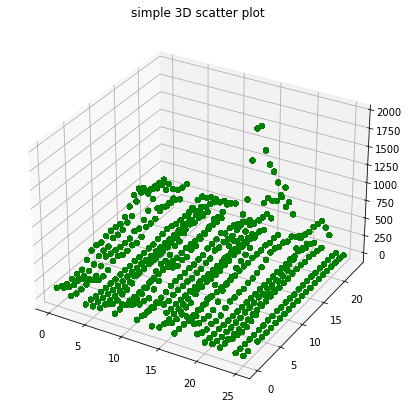

In [185]:
# view data
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x_train.data.numpy()[:,0], x_train.data.numpy()[:,1], y_train.data.numpy(), color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

## Now we train

In [205]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)
        
    def forward(self, x):
        
        #x = [batch size, height, width]
        
        batch_size = x.shape[0]

        x = x.view(batch_size, -1)
        
        #x = [batch size, height * width]
        
        h_1 = F.relu(self.input_fc(x))
        
        #h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        #h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        
        #y_pred = [batch size, output dim]
        
        return y_pred

In [213]:
net = MLP(input_dim=2, output_dim=1)     # define the network
print(net)  # net architecture
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
loss_func = loss_func.to(device)

MLP(
  (input_fc): Linear(in_features=2, out_features=250, bias=True)
  (hidden_fc): Linear(in_features=250, out_features=100, bias=True)
  (output_fc): Linear(in_features=100, out_features=1, bias=True)
)


In [214]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [215]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [210]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
            
            
            y_pred = model(x)
            
            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [191]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [216]:
EPOCHS = 100

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(net, train_iterator, optimizer, loss_func, device)
    valid_loss, valid_acc = evaluate(net, valid_iterator, loss_func, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), 'tut1-model.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 54213.520 | Train Acc: 0.00%
	 Val. Loss: 53170.756 |  Val. Acc: 0.00%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 51781.720 | Train Acc: 0.00%
	 Val. Loss: 52824.543 |  Val. Acc: 0.00%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 51657.802 | Train Acc: 0.00%
	 Val. Loss: 52814.617 |  Val. Acc: 0.00%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 51603.954 | Train Acc: 0.00%
	 Val. Loss: 52798.186 |  Val. Acc: 0.00%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 51688.907 | Train Acc: 0.00%
	 Val. Loss: 52834.253 |  Val. Acc: 0.00%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 51689.592 | Train Acc: 0.00%
	 Val. Loss: 52816.418 |  Val. Acc: 0.00%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 51654.686 | Train Acc: 0.00%
	 Val. Loss: 52800.970 |  Val. Acc: 0.00%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 51649.021 | Train Acc: 0.00%
	 Val. Loss: 52883.447 |  Val. Acc: 0.00%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 51604.353 | Train Acc: 0.00%
	 Val. Loss: 527

KeyboardInterrupt: 

In [217]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [289]:
regr = MLPRegressor( hidden_layer_sizes=(600,300,200,100),max_iter=1000, shuffle=True, verbose=True, solver='adam').fit(X_train, Y_train)



Iteration 1, loss = 53.35532054
Iteration 2, loss = 50.24816987
Iteration 3, loss = 49.84583229
Iteration 4, loss = 49.47932520
Iteration 5, loss = 49.88644497
Iteration 6, loss = 49.67198319
Iteration 7, loss = 49.45009583
Iteration 8, loss = 49.24254778
Iteration 9, loss = 49.21433303
Iteration 10, loss = 49.03410023
Iteration 11, loss = 49.04846623
Iteration 12, loss = 49.04382864
Iteration 13, loss = 48.97713089
Iteration 14, loss = 49.21939927
Iteration 15, loss = 48.99891728
Iteration 16, loss = 49.04344649
Iteration 17, loss = 48.69479165
Iteration 18, loss = 48.89908489
Iteration 19, loss = 48.70301747
Iteration 20, loss = 48.66774282
Iteration 21, loss = 48.41293047
Iteration 22, loss = 48.36174746
Iteration 23, loss = 48.92158247
Iteration 24, loss = 47.99133117
Iteration 25, loss = 47.97021820
Iteration 26, loss = 47.37125116
Iteration 27, loss = 47.47850713
Iteration 28, loss = 46.20190692
Iteration 29, loss = 46.62926568
Iteration 30, loss = 44.66670840
Iteration 31, loss 

In [290]:
regr.score(X_test, Y_test)

0.524220175866402

In [291]:
regr.predict(X_test[:10])

array([ 1.88205724,  7.35320516,  2.27019308, 10.03900048,  2.62283529,
        1.54669694,  4.96610547, 26.19658156,  5.23883978, 12.91046084])